# Dataset importation

At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


# Preliminary analysis -  NaN indentification

The complete description of the dataset can be found [here](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md). Since our purpose is to train a ML model to predict the skin colour from the player's description, we perform an essential qualitative analysis to understand the features of the dataset.
Above all, we take a look at the skin colour distribution, which is described by the attributes *rater1* and *rater2*.

In [3]:
# NaN identification
nans = [data.rater1.isnull().value_counts(),data.rater2.isnull().value_counts() ]
nans

[False    124621
 True      21407
 Name: rater1, dtype: int64, False    124621
 True      21407
 Name: rater2, dtype: int64]

There is a proportion of **14.7%** of NaN values. We notice that the NaN values affect the same players both for the attribute *rater1* and for *rater2*:

In [4]:
(data.rater1.isnull()==data.rater2.isnull()).value_counts()

True    146028
dtype: int64

Therefore, there are players for which the attribute *skin color* cannot be predicted directly from the dataset. Since this is the feature we want to study, we throw away the missing values:

In [5]:
data.dropna(axis=0, subset=['rater1'],inplace=True)

# Preliminary analysis - qualitative overlook

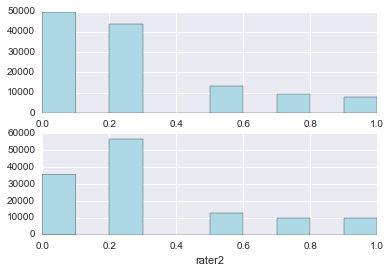

In [6]:
plt.subplot(2,1,1)
plt.hist(data.rater1,color='lightblue')
plt.xlabel('rater1')
plt.subplot(2,1,2)
plt.hist(data.rater2,color='lightblue')
plt.xlabel('rater2')

The two ratings are actually different, due to a subjective evaluation of the skin color. We plot now their difference:

(array([ 95714.,      0.,      0.,      0.,      0.,  28743.,      0.,
             0.,      0.,    164.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ]),
 <a list of 10 Patch objects>)

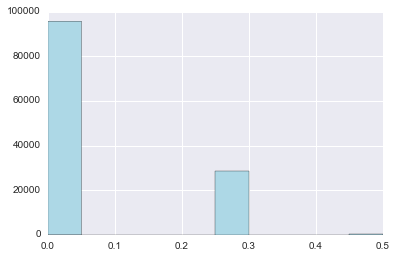

In [7]:
plt.hist(abs(data.rater2-data.rater1),color='lightblue',bins=10)

As it appears from the histogram, there are 3 observed values (0, 0.25 and 0.5) for the rating's difference in absolute value (which of course depends on the quantization of the skin color into categories). This shows that the sensibility of the evaluators may differ for at most 0.5. The proportions of rating's differences out of the total amount of players is summed-up below:

In [8]:
abs(data.rater2-data.rater1).value_counts()/len(data)*100

0.00    76.804070
0.25    23.064331
0.50     0.131599
dtype: float64

The proportions for the signed difference are instead given by:

In [9]:
(data.rater2-data.rater1).value_counts()/len(data)*100

 0.00    76.804070
 0.25    19.121978
-0.25     3.942353
 0.50     0.131599
dtype: float64

We observe that the second rater has a systematic higher perception of the skin colour with respect to the first one. For our analysis purposes, we define a new attribute ***skinColor*** as the mean of the two evaluations. This will be the quantity we want to predict:

In [10]:
data['skinColor']=0.5*(data.rater1+data.rater2)
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColor
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


# Analysis of features

Let us now begin the real analysis of the dataset. Before applying any machine learning algorithm, we visualize the interactions between some feature we think are more significant than others for our purposes:
- leagueCountry
- height
- weight
- position
- skinColor (mean of the ratings, previously defined)

In [24]:
# quantize the parameter leagueCountry: 0 - England, 1 - France, 2 - Germany, 3 - Spain
leagueToNum = {'England' : 0, 'France' : 1, 'Germany' : 2, 'Spain' : 3}
league = []
for i in data.leagueCountry:
    league.append(leagueToNum[i])
data['leagueID']=league

Skin color - height:

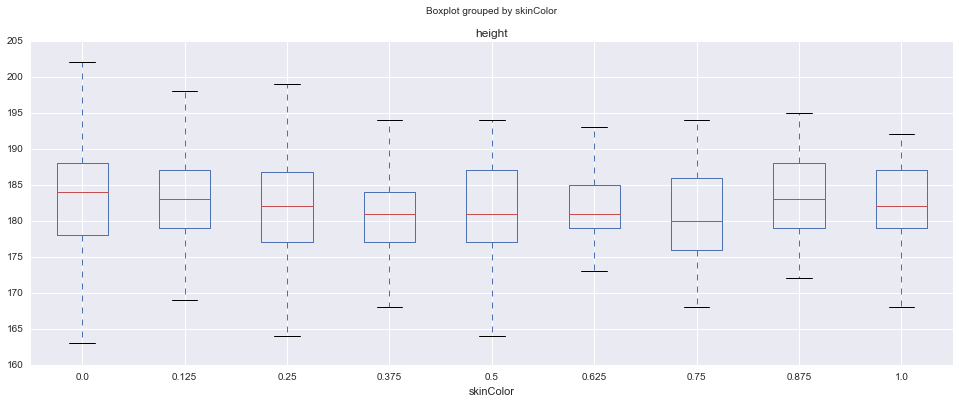

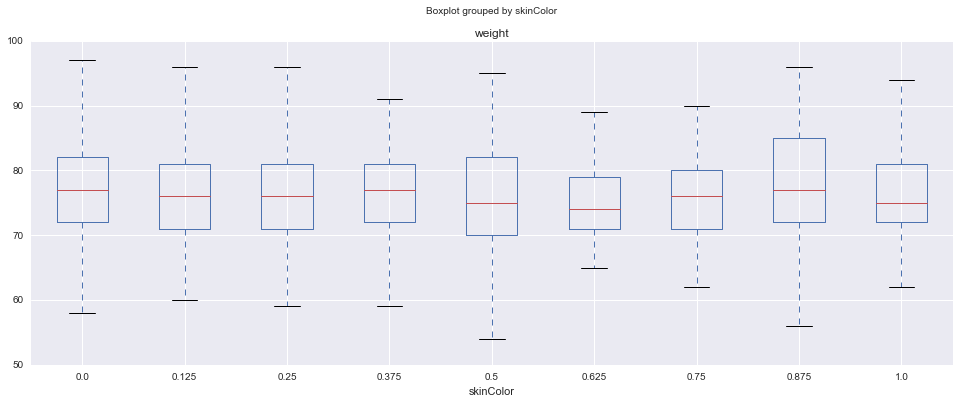

In [44]:
data.boxplot(by='skinColor',column='height',figsize=(16,6))
data.boxplot(by='skinColor',column='weight',figsize=(16,6))

Height - weight interaction grouped by skin:

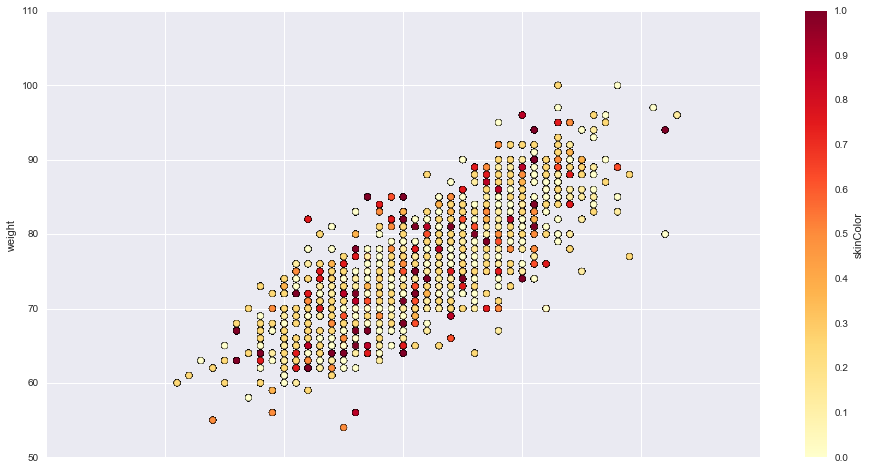

In [45]:
data.plot(kind='scatter',x = 'height', y='weight', c = 'skinColor', s=40, cmap = 'YlOrRd',figsize=(16,8))

From these first plot, we can observe that:
1. Height seems to be more variable for white-race players than for black-race ones;
2. Weight and skin color seem less correlated, because the distribution is more uniform than for height;
3. There is a clear correlation between height and weight, independently on the skin color. This relation may be well approximated by a linear regression straight line, but the variance of the sample is anyway quite high.
These results are very reasonable on a qualitative point of view; in particular, we expect that height would be a more discriminant feature for the skin color than the other two considered parameters.

Let us now examine the behaviour with respect to the *leagueID* parameter (which is a numerical translation of the Country name):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000163DDEF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000016324898>]], dtype=object)

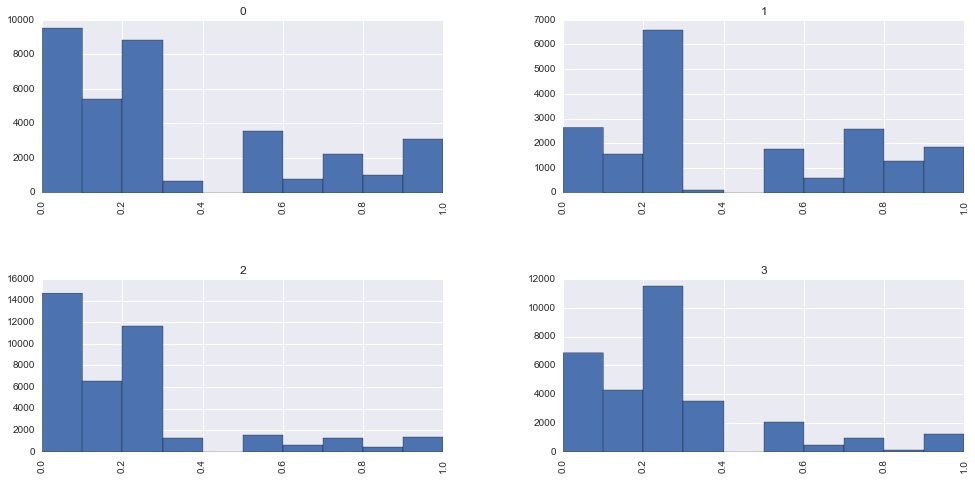

In [49]:
data.hist(column = 'skinColor', by = 'leagueID', figsize=(16,8))

Also in this case we obtain reasonable results:
- **England** and **Germany** show a higher white-race (Viking) component;
- **England** and **France** show a higher black-race component, since traditionally these countries have had a more significant immigration rate from African Countries;
- **Spain** and **France** have a higher "middle race" component, coming probably from the Latin races.

We try now to merge these information into one bigger scatterplot, where we look at weight vs. height and depict as the markers' size the skin color and with colors the league Country (try to comment some lines of the scatterplot to visualize fewer Countries):

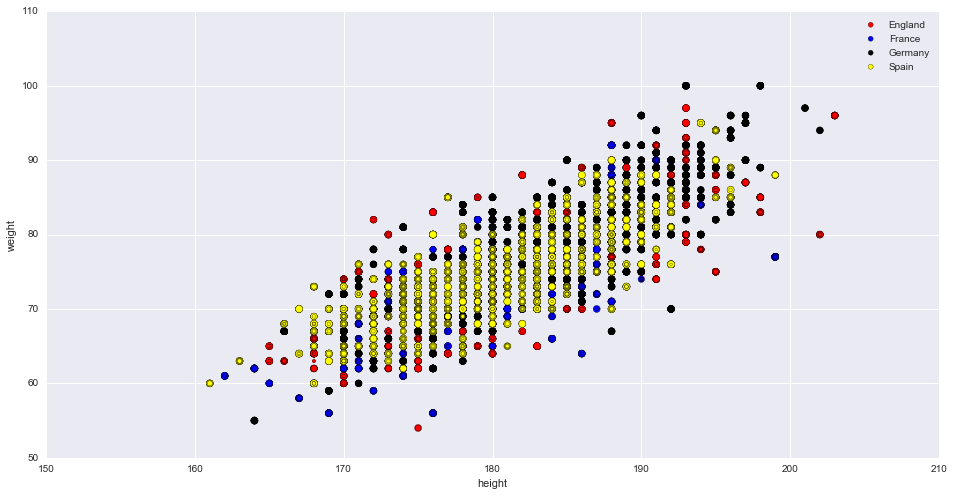

In [62]:
ax = data[data.leagueID==0].plot(kind='scatter',x = 'height', y='weight', s=data['skinColor']*50, color='red',figsize=(16,8),label='England')
data[data.leagueID==1].plot(kind='scatter',x = 'height', y='weight', s=data['skinColor']*50, color='blue',figsize=(16,8),ax=ax,label='France')
data[data.leagueID==2].plot(kind='scatter',x = 'height', y='weight', s=data['skinColor']*50, color='black',figsize=(16,8),ax=ax,label='Germany')
data[data.leagueID==3].plot(kind='scatter',x = 'height', y='weight', s=data['skinColor']*50, color='yellow',figsize=(16,8),ax=ax,label='Spain')